In [1]:
import h5py
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib.patches import Polygon
import colorcet as cc
import colormath, colormath.color_objects, colormath.color_conversions
from colormath.color_objects import sRGBColor
import urllib
import re
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import shapely.geometry as sgeom
from itertools import chain
import copy
%matplotlib inline

/global/homes/f/feng045/envs/py310_home/lib/python3.12/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
xr.__version__

'2024.5.0'

In [3]:
# PHASE = 'Summer'
PHASE = 'Winter'

run_name1 = 'OBSv7'
# run_name2 = 'SCREAM'
# run_name2 = 'OBSv7'
# run_name1 = 'SCREAM'
# run_name2 = 'SCREAMv1'

tracker = 'PyFLEXTRKR'

lat_bounds = (-60.,60.)

indir = f'/pscratch/sd/f/feng045/DYAMOND/mcs_stats/{PHASE}/{tracker}/'
infile1 = f'{indir}mcs_rainmap_{PHASE}_{run_name1}.nc'
infile2 = f'/pscratch/sd/f/feng045/DYAMOND/GPM_DYAMOND/GPM_3IMERGHH_V07B/monthly/3B-MO.MS.MRG.3IMERG.20200201-S000000-E235959.02.V07B.HDF5'

topfile = '/global/cfs/cdirs/m1867/zfeng/gpm/map_data/era5_orography.nc'

figdir = f'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/{PHASE}/figures/{tracker}/'
os.makedirs(figdir, exist_ok=True)
print(figdir)
print(f'{infile1} exists: {os.path.isfile(infile1)}')
print(f'{infile2} exists: {os.path.isfile(infile2)}')

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/PyFLEXTRKR/
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR/mcs_rainmap_Winter_OBSv7.nc exists: True
/pscratch/sd/f/feng045/DYAMOND/GPM_DYAMOND/GPM_3IMERGHH_V07B/monthly/3B-MO.MS.MRG.3IMERG.20200201-S000000-E235959.02.V07B.HDF5 exists: True


# These customed functions enables use of [NCL colormaps](https://www.ncl.ucar.edu/Document/Graphics/color_table_gallery.shtml)

In [4]:
color_obj_dict = {'sRGB':colormath.color_objects.sRGBColor,
                  'HSV':colormath.color_objects.HSVColor,
                  'Lab':colormath.color_objects.LabColor,
                  'LCHuv':colormath.color_objects.LCHuvColor,
                  'LCHab':colormath.color_objects.LCHabColor,
                  'XYZ':colormath.color_objects.XYZColor}

def __rgb_to_array(rgb_color):
    r = np.minimum(1, round(rgb_color.rgb_r*10000)/10000)
    g = np.minimum(1, round(rgb_color.rgb_g*10000)/10000)
    b = np.minimum(1, round(rgb_color.rgb_b*10000)/10000)
    return r,g,b


def create_palette(start_rgb, end_rgb, n, colorspace):
    # convert start and end to a point in the given colorspace
    start = colormath.color_conversions.convert_color(start_rgb, colorspace).get_value_tuple()
    end = colormath.color_conversions.convert_color(end_rgb, colorspace).get_value_tuple()

    # create a set of n points along start to end
    points = list(zip(*[np.linspace(start[i], end[i], n) for i in range(3)]))

    # create a color for each point and convert back to rgb
    rgb_colors = [colormath.color_conversions.convert_color(colorspace(*point), sRGBColor) for point in points]

    # finally convert rgb colors back to hex
    return [__rgb_to_array(color) for color in  rgb_colors]


def __retrive_NCL_webcontent(cmapname):
    target_url = 'https://www.ncl.ucar.edu/Document/Graphics/ColorTables/Files/%s.rgb' % cmapname
    request = urllib.request.urlopen(target_url)
    return request


def __collect_discrete_NCL_cmap(cmapname):
    rawdata = __retrive_NCL_webcontent(cmapname)
    
    cmap_color_list = list()
    
    color_section_sig = 0
    
    for line in rawdata:
        
        line_decode = line.decode('utf-8')
        info = re.split('\s+', line_decode.replace('\n','').replace('^\s+',''))

        if color_section_sig==1:
            if info[0]=='' and len(info)>=3:
                if np.maximum(np.maximum(float(info[1]), float(info[2])), float(info[3]))>1:
                    cmap_color_list.append((float(info[1])/255, float(info[2])/255, float(info[3])/255))
                else:
                    cmap_color_list.append((float(info[1]), float(info[2]), float(info[3])))
            if len(info)==3:
                if ';' in info[0] or '#' in info[0]:
                    whatisthis = 's'
                else:
                    if np.maximum(np.maximum(float(info[0]), float(info[1])), float(info[2]))>1:
                        cmap_color_list.append((float(info[0])/255, float(info[1])/255, float(info[2])/255))
                    else:
                        cmap_color_list.append((float(info[0]), float(info[1]), float(info[2])))
        
        if 'ncolors' in str(info[0]):
            color_section_sig = 1  # meaning now we are at color lines (or "r g b" line)

    return cmap_color_list


def __cmap_refinement(raw_cmap_rgb, n_interpolate=10, workspace=color_obj_dict['sRGB']):
    # workspace:  choose which color space the refinement is conducted.
    #             refer to https://stackoverflow.com/questions/55032648/given-a-start-color-and-a-middle-color-how-to-get-the-remaining-colors-python

    n_in = len(raw_cmap_rgb)

    new_array = list()

    for i in np.arange(n_in-1):
        out_colors = create_palette(sRGBColor(*raw_cmap_rgb[i], is_upscaled=False), sRGBColor(*raw_cmap_rgb[i+1], is_upscaled=False), n_interpolate+1, workspace)
        for j in np.arange(len(out_colors)-1):
            new_array.append(out_colors[j])

    return new_array


def generate_NCL_cmap(cmapname, cont_opt=False, cont_param_n=10, cont_param_ws='sRGB',
                      white_first=False, white_ext=False, reverse_cmap=False):
    # description:
    #     cmapname:      taken as shown on the NCL website
    #     cont_opt:      to convert the discreate colormap to continuous colormap
    #     cont_param_n:  how many "intermediate" colors to be inserted to the nearby discreate colors
    #     cont_param_ws: color space to conduct interploation. Default to "sRGB", which should work for most cases
    #     white_first:   whether to set the first color as white. May be useful if the minimum does not mean anything
    #     white_ext:     whether to add this above white as an extended color (when set to True), or just replace the first color (when set to False).
    #     reverse_cmap:  similar to "_r" in colormap.
    # note:  reverse_cmap is applied first, then white_first option.

    cmap_discrete_raw = __collect_discrete_NCL_cmap(cmapname)

    if reverse_cmap==True:
        cmap_discrete_raw.reverse()

    if white_first==True:
        if white_ext==True:
            cmap_discrete = list()
            cmap_discrete.append((1,1,1))
            for i in np.arange(len(cmap_discrete_raw)):
                cmap_discrete.append(cmap_discrete_raw[int(i)])
        else:
            cmap_discrete = cmap_discrete_raw.copy()
        cmap_discrete[0] = (1,1,1)
    else:
        cmap_discrete = cmap_discrete_raw

    if cont_opt==False:
        out_cmap = cmap_discrete

    if cont_opt==True:
        out_cmap = __cmap_refinement(cmap_discrete, n_interpolate=cont_param_n, workspace=color_obj_dict[cont_param_ws])

    return mpl.colors.ListedColormap(out_cmap)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """ Truncate colormap.
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

<>:46: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1570158/1696920108.py:46: SyntaxWarning: invalid escape sequence '\s'
  info = re.split('\s+', line_decode.replace('\n','').replace('^\s+',''))
/tmp/ipykernel_1570158/1696920108.py:46: SyntaxWarning: invalid escape sequence '\s'
  info = re.split('\s+', line_decode.replace('\n','').replace('^\s+',''))


In [5]:
# Read topography data
dstop = xr.open_dataset(topfile)
# Convert surface geopotential to height in meters
ter = dstop.z.sel(latitude=slice(61,-61)).squeeze() / 9.80665
ter_s = gaussian_filter(ter, 1)
lon_ter = dstop.longitude
lat_ter = dstop.latitude.sel(latitude=slice(61,-61))
ter

<xarray.DataArray 'z' (latitude: 489, longitude: 1440)> Size: 6MB
array([[-0.19079558, -0.28235992,  0.17546177, ...,  1.1826695 ,
         0.35859045,  0.26702611],
       [-0.19079558,  0.54171913,  0.35859045, ...,  2.28144156,
         1.36579817,  0.99954082],
       [-1.655825  , -0.92331029,  0.08389743, ...,  7.1343515 ,
         0.90797648, -0.55705294],
       ...,
       [ 0.35859045,  0.17546177,  0.17546177, ..., -0.4654886 ,
        -0.37392426,  0.17546177],
       [-0.37392426, -0.09923124,  0.08389743, ...,  0.35859045,
         0.17546177,  0.17546177],
       [-0.0076669 ,  0.26702611, -0.0076669 , ...,  0.08389743,
         0.17546177,  0.54171913]])
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 2kB 61.0 60.75 60.5 ... -60.5 -60.75 -61.0
    time       datetime64[ns] 8B 1979-01-01

In [6]:
# import h5py

# file_path = 'your_file.h5'

# with h5py.File(infile2, 'r') as f:
#     def print_attrs(name, obj):
#         print(name, dict(obj.attrs))
#     f.visititems(print_attrs)

In [7]:
with h5py.File(infile2, 'r') as f:
    # Example: assuming data is stored in a group 'group_name' with a dataset 'data'
    # data = f['Grid'][:]
    data = f['Grid/precipitation'][:]
    attrs = dict(f['Grid'].attrs)
    # print(data['precipitation'])
    dims = ('time', 'lon', 'lat')  # Replace with actual dimension names
    # coords = {'time':data['time'], 'lon':data['lon'], 'lat':data['lat']}
    xcoord = f['Grid/lon'][:]
    ycoord = f['Grid/lat'][:]
    tcoord = f['Grid/time'][:]
    # coords = {'time': np.arange(data.shape[0]), 'lon': np.arange(data.shape[1]), 'lat': np.arange(data.shape[2])}
    coords = {'time': tcoord, 'lon': xcoord, 'lat': ycoord}
    # coords = {'time': np.arange(data.shape[0]), 'lon': np.arange(data.shape[1]), 'lat': np.arange(data.shape[2])}  # Replace with actual coordinates if available

In [8]:
pcp_monthly = xr.DataArray(data, dims=dims, coords=coords, attrs=attrs)
# pcp_monthly = xr.Dataset({'precipitation': pcp_monthly})
# Transpose dimensions
pcp_monthly = pcp_monthly.transpose('time','lat','lon')

# Define the reference time
reference_time = pd.Timestamp('1980-01-06 00:00:00 UTC')
# Convert the integer time coordinate to a decoded datetime
decoded_time = reference_time + pd.to_timedelta(pcp_monthly['time'].values, unit='s')
# Update the DataArray with the decoded time coordinate
pcp_monthly = pcp_monthly.assign_coords({'time':decoded_time.values})

# Subset lat bounds
pcp_monthly = pcp_monthly.sel(lat=slice(min(lat_bounds), max(lat_bounds)))

In [9]:
# data_array = xr.DataArray(data, dims=dims, coords=coords, attrs=attrs)

In [10]:
# ds2 = xr.open_dataset(infile2, engine='h5netcdf')
# ds2 = xr.open_dataset(infile2, engine='netcdf4')
# ds2

In [11]:
ds1 = xr.open_dataset(infile1)
lon = ds1.lon
lat = ds1.lat
ds1

<xarray.Dataset> Size: 69MB
Dimensions:                  (time: 1, lat: 1200, lon: 3600)
Coordinates:
  * time                     (time) datetime64[ns] 8B 2020-02-01
  * lat                      (lat) float64 10kB -59.95 -59.85 ... 59.85 59.95
  * lon                      (lon) float64 29kB -179.9 -179.8 ... 179.8 179.9
Data variables:
    precipitation            (time, lat, lon) float32 17MB ...
    mcs_precipitation        (time, lat, lon) float32 17MB ...
    mcs_precipitation_count  (time, lat, lon) float32 17MB ...
    mcs_cloud_count          (time, lat, lon) float32 17MB ...
    ntimes                   (time) float32 4B ...
Attributes:
    Title:       MCS precipitation accumulation
    phase:       Winter
    tracker:     PyFLEXTRKR
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    start_date:  2020-02-01T00
    end_date:    2020-03-01T00
    created_on:  Thu Mar 21 13:05:09 2024

In [12]:
# Total number of hours
nhours = ds1.ntimes.sum(dim='time')
print(f'Number of total hours: {nhours.data}')

# Sum monthly precipitation amount [mm], divided by total number of hours to get [mm/h]
# then x24 to get [mm/day]
pcp1 = 24. * ds1.precipitation.sum(dim='time') / nhours
pcp1

Number of total hours: 697.0


<xarray.DataArray (lat: 1200, lon: 3600)> Size: 17MB
array([[4.0445337 , 3.7020946 , 3.5924246 , ..., 4.3595986 , 4.229096  ,
        4.1294127 ],
       [4.0085497 , 3.755121  , 3.4553804 , ..., 4.166943  , 3.9288378 ,
        4.06485   ],
       [4.0670877 , 3.9736009 , 3.837933  , ..., 4.0130277 , 4.0467725 ,
        4.001837  ],
       ...,
       [0.45331433, 0.42129135, 0.43489248, ..., 0.43936887, 0.41560987,
        0.4484937 ],
       [0.42094705, 0.41096136, 0.42146343, ..., 0.40527982, 0.40390256,
        0.4273172 ],
       [0.33744633, 0.38203743, 0.3947778 , ..., 0.27804884, 0.30421814,
        0.3262555 ]], dtype=float32)
Coordinates:
  * lat      (lat) float64 10kB -59.95 -59.85 -59.75 ... 59.75 59.85 59.95
  * lon      (lon) float64 29kB -179.9 -179.8 -179.8 ... 179.8 179.8 179.9

In [13]:
pcp2 = 24. * pcp_monthly.squeeze()
pcp2 = pcp2.assign_coords({'lat':lat, 'lon':lon})

In [14]:
pcp1 = pcp1.roll(lon=1800, roll_coords=True)
pcp2 = pcp2.roll(lon=1800, roll_coords=True)
lon360 = ds1.lon.roll(lon=1800) % 360
pcp1 = pcp1.assign_coords(lon=lon360)
pcp2 = pcp2.assign_coords(lon=lon360)

lon = lon360
lat = lat

In [15]:
pcpdiff = pcp2 - pcp1
pcpdiff

<xarray.DataArray (lat: 1200, lon: 3600)> Size: 17MB
array([[-0.00272   , -0.00991642, -0.01153481, ..., -0.00034392,
        -0.01081192, -0.0094347 ],
       [-0.00034404,  0.0121206 , -0.00571573, ...,  0.00571609,
        -0.00943446,  0.00082636],
       [ 0.0096755 ,  0.00127435, -0.0010674 , ..., -0.00334001,
         0.00258279, -0.01384223],
       ...,
       [ 0.01312208,  0.00874901,  0.01866436, ...,  0.02485847,
         0.00468349,  0.00898695],
       [ 0.00888491,  0.00502682,  0.01143265, ...,  0.0240674 ,
         0.00454807,  0.02138472],
       [ 0.01274157,  0.00110197,  0.01873112, ...,  0.02217627,
         0.00354958,  0.01735687]], dtype=float32)
Coordinates:
    time     datetime64[ns] 8B 2020-02-01
  * lat      (lat) float64 10kB -59.95 -59.85 -59.75 ... 59.75 59.85 59.95
  * lon      (lon) float64 29kB 0.05 0.15 0.25 0.35 ... 359.6 359.8 359.9 359.9

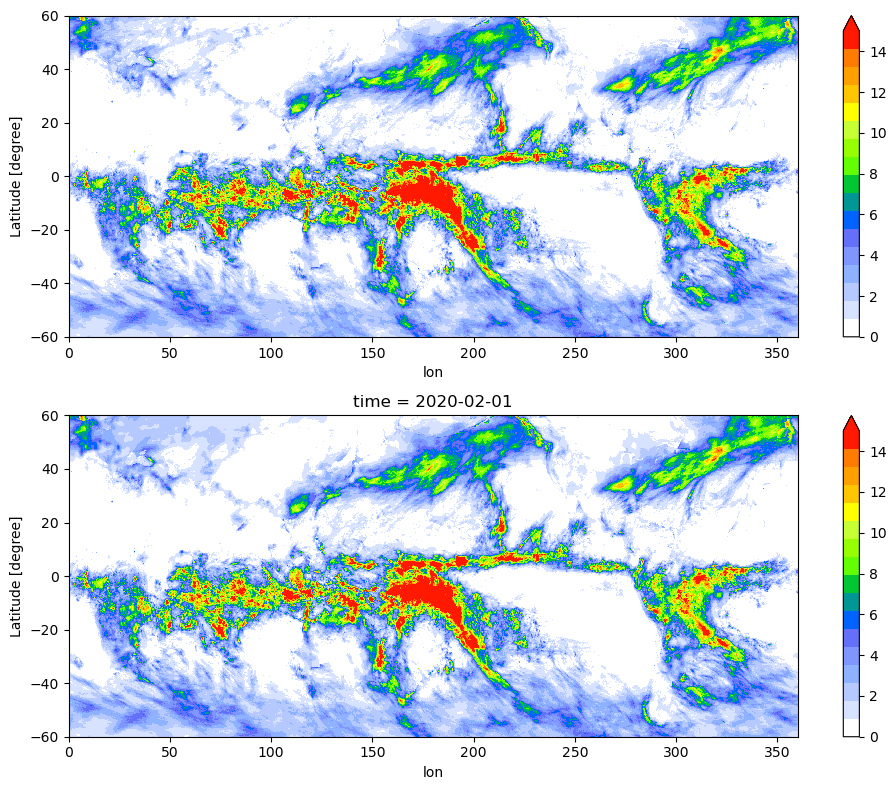

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(10,8), dpi=100)
cmap = generate_NCL_cmap('precip3_16lev', cont_param_ws='sRGB')
pcp1.plot(vmin=0, vmax=15, cmap=cmap, ax=axes[0])
pcp2.plot(vmin=0, vmax=15, cmap=cmap, ax=axes[1])
# mcspcp_diff.plot(vmin=-15, vmax=15, cmap='BrBG', ax=axes[1])
fig.tight_layout()

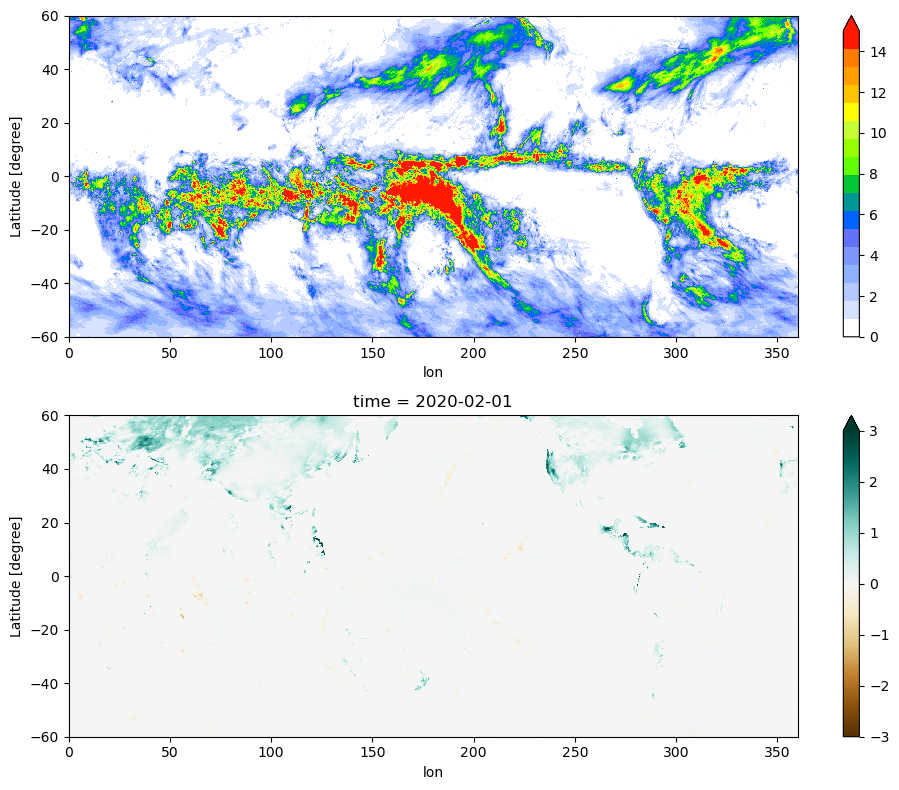

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(10,8), dpi=100)
cmap = generate_NCL_cmap('precip3_16lev', cont_param_ws='sRGB')
pcp1.plot(vmin=0, vmax=15, cmap=cmap, ax=axes[0])
pcpdiff.plot(vmin=-3, vmax=3, cmap='BrBG', ax=axes[1])
fig.tight_layout()

## Specify regional boundaries for calculating mean values

In [18]:
if PHASE == 'Winter':
    box_mc = [95%360,150%360,-20,5]
    box_itcz = [151%360,-110%360,0,12]
    box_spcz = [151%360,-150%360,-30,-1]
    box_io = [50%360,94%360,-15,5]
    box_afc = [10%360,40%360,-20,5]
    box_amz = [-75%360,-40%360,-20,0]
    box_ao = [-40%360,-10%360,-8,8]
    box_amz180 = [-75,-40,-20,0]
    box_ao180 = [-40,-10,-8,8]
    boxes = {'MC':box_mc, 
             'ITCZ':box_itcz, 
             'SPCZ':box_spcz, 
             'IO':box_io, 
             'AO':box_ao,
             'AFC':box_afc, 
             'AMZ':box_amz, 
             }
    region_names = dict(zip(boxes.keys(), boxes.keys()))

    # Calculate regional mean difference
    diff_reg = np.zeros(len(boxes), dtype=float)
    text_loc_x = np.zeros(len(boxes), dtype=float)
    for ii, name in enumerate(boxes):
        text_loc_x[ii] = boxes[name][0] + (boxes[name][1] - boxes[name][0])/2.
    text_loc_y = [
        boxes['MC'][3]+3,
        boxes['ITCZ'][3]+3,
        boxes['SPCZ'][2]-8, 
        boxes['IO'][2]-8, 
        boxes['AO'][3]+3,
        boxes['AFC'][2]-8, 
        boxes['AMZ'][2]-8,         
    ]
    text_loc = dict(zip(boxes.keys(), zip(text_loc_x, text_loc_y)))
    print(boxes)

{'MC': [95, 150, -20, 5], 'ITCZ': [151, 250, 0, 12], 'SPCZ': [151, 210, -30, -1], 'IO': [50, 94, -15, 5], 'AO': [320, 350, -8, 8], 'AFC': [10, 40, -20, 5], 'AMZ': [285, 320, -20, 0]}


In [19]:
if PHASE == 'Summer':
    box_mc = [95,150,-20,5]
    box_itcz = [-179,-70,5,18]
    box_io = [50,94,-15,5]
    box_wpac = [125,178,0,30]
    box_sam = [70,125,5,40]
    box_afc = [-15,40,-5,18]
    box_amz = [-75,-40,-20,0]
    box_ao = [-60,-15,5,18]
    box_cus = [-105, -80, 30, 50]
    box_ao180 = [-60,-15,5,18]
    box_cus180 = [-105, -80, 30, 50]
    boxes = {
        'WP':box_wpac,
        'ITCZ':box_itcz, 
        'IO':box_io, 
        'AO':box_ao,
        'AFC':box_afc, 
        'SAM':box_sam,
        'CUS':box_cus,
    }
    region_names = dict(zip(boxes.keys(), boxes.keys()))
    
    # Calculate regional mean difference
    diff_reg = np.zeros(len(boxes), dtype=float)
    text_loc_x = np.zeros(len(boxes), dtype=float)
    for ii, name in enumerate(boxes):
        text_loc_x[ii] = boxes[name][0] + (boxes[name][1] - boxes[name][0])/2.
    text_loc_y = [
        boxes['WP'][3]+3,
        boxes['ITCZ'][3]+3, 
        boxes['IO'][2]-8, 
        boxes['AO'][3]+3,
        boxes['AFC'][2]-8, 
        boxes['SAM'][3]+3,
        boxes['CUS'][3]+3,
    ]
    text_loc = dict(zip(boxes.keys(), zip(text_loc_x, text_loc_y)))

In [20]:
totpcp_reg_s1 = np.zeros(len(boxes), dtype=float)
totpcp_reg_s2 = np.zeros(len(boxes), dtype=float)
diff_totpcp_reg = np.zeros(len(boxes), dtype=float)
text_loc_x = np.zeros(len(boxes), dtype=float)

for ii, name in enumerate(boxes):
    # print(name)
    xid = np.where((lon >= boxes[name][0]) & (lon <= boxes[name][1]))[0]
    yid = np.where((lat >= boxes[name][2]) & (lat <= boxes[name][3]))[0]
    text_loc_x[ii] = boxes[name][0] + (boxes[name][1] - boxes[name][0])/2.
    # Calculate mean difference in percentage
    # Total rain
    tot_s2 = pcp2.data[min(yid):max(yid), min(xid):max(xid)]
    tot_s1 = pcp1.data[min(yid):max(yid), min(xid):max(xid)]
    totpcp_reg_s1[ii] = np.nanmean(tot_s1)
    totpcp_reg_s2[ii] = np.nanmean(tot_s2)
    diff_totpcp_reg[ii] = 100 * (np.nansum(tot_s2) - np.nansum(tot_s1)) / np.nansum(tot_s1)

# Put mean values in dictionaries
text_loc = dict(zip(boxes.keys(), zip(text_loc_x, text_loc_y)))
text_val_totpcp_diff = dict(zip(boxes.keys(), diff_totpcp_reg))

text_val_totpcp_s1 = dict(zip(boxes.keys(), [f"{value:.1f} mm/d" for value in totpcp_reg_s1]))
text_val_totpcp_s2 = dict(zip(boxes.keys(), [f"{value:.1f} mm/d" for value in totpcp_reg_s2]))
# Shift SPCZ text location for Winter
if PHASE == 'Winter':
    text_loc['SPCZ'] = text_loc['SPCZ'][0] + 20, text_loc['SPCZ'][1]
# print(text_loc)
print(text_val_totpcp_diff)

{'MC': 0.05485735356297046, 'ITCZ': 0.01733725256145867, 'SPCZ': 0.0999477247097735, 'IO': -0.15219638461668716, 'AO': 0.05196130378347152, 'AFC': 0.053309200228271805, 'AMZ': 0.03926410436281931}


In [21]:
def plot_2maps_1cb(dataarray, lon, lat, titles, levels, cmap, cblabel, cbticks, figname, 
                   oob_colors=None, contourf=False, 
                   boxes=None, boxtextloc=None, boxtext=None, boxtexttype=None, text_colors=None):
    
    mpl.rcParams['font.size'] = 12
    # mpl.rcParams['font.family'] = 'Helvetica'

    # map_extent = [0., 359.5, -60.1, 60.1]
    map_extent = [-180., 179.9, -60.1, 60.1]
    lonv = np.arange(-180,180.1,30)
    lonv = np.arange(-180,180.1,30)
    latv = np.arange(-60,60.1,15)
    proj = ccrs.PlateCarree(central_longitude=0)
    data_proj = ccrs.PlateCarree()
    levelshgt = [1000,10000]

    fig = plt.figure(figsize=[12,8], dpi=100)
    gs = gridspec.GridSpec(2,1, height_ratios=[1,1], width_ratios=[1])
    gs.update(left=0.05, right=0.88, bottom=0.1, top=0.9, wspace=0.05, hspace=0.14)

    resolution = '110m'
    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
    
    # text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}
    
    for pp in range(0,2):
        data = dataarray[pp]

        ax = plt.subplot(gs[pp], projection=proj)
        ax.set_extent(map_extent, crs=proj)
        ax.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
        ax.set_title(titles[pp], loc='left')
        ax.set_aspect('auto', adjustable=None)
        # Lat/lon grid
        gl = ax.gridlines(crs=proj, draw_labels=False, linestyle='--', linewidth=0.5)
        gl.xlocator = mpl.ticker.FixedLocator(lonv)
        gl.ylocator = mpl.ticker.FixedLocator(latv)           
        if (pp == 1):
            ax.set_xticks(lonv, crs=data_proj)
            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_yticks(latv, crs=data_proj)
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        
        # Terrain height
        ct = ax.contour(lon_ter, lat_ter, ter_s, levels=[1000,1001], \
                        colors='dimgray', linewidths=1, transform=data_proj, zorder=3)
        
        Zm = np.ma.masked_where(((data == 0) | (np.isnan(data))), data)
        cmap = copy.copy(mpl.colormaps.get_cmap(cmap))
        norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
        if (contourf == False):
            cf1 = ax.pcolormesh(lon, lat, Zm, shading='auto', norm=norm, cmap=cmap, transform=data_proj, zorder=2)
        else:
            cf1 = ax.contourf(lon, lat, Zm, levels=levels, norm=norm, cmap=cmap, transform=data_proj, extend='both', zorder=2)
        # Set out-of-bound colors
        if oob_colors is not None:
            cf1.cmap.set_over(oob_colors['over'])
            cf1.cmap.set_under(oob_colors['under'])
            cf1.set_clim(min(levels), max(levels))

        # Plot boxes
        if boxes is not None:
            for ii in boxes:
                # Plot region boxes
                corners = [[boxes[ii][0],boxes[ii][2]], [boxes[ii][1],boxes[ii][2]], [boxes[ii][1],boxes[ii][3]], [boxes[ii][0],boxes[ii][3]]]
                box = Polygon(corners, edgecolor='k', facecolor='none', lw=2, transform=data_proj, zorder=10)
                ax.add_patch(box)

                if boxtexttype is None:
                    text_color = text_colors['pos'] if (boxtext[pp][ii] >=0) else text_colors['neg']
                    ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[pp][ii]:.00f}%", ha='center',
                            bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
                            fontsize=12, fontweight='bold', color=text_color, transform=data_proj, zorder=4)
                else:
                    text_color = 'k'
                    ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[pp][ii]}", ha='center',
                            bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
                            fontsize=12, fontweight='bold', color=text_color, transform=data_proj, zorder=4)

    # Plot 1 colorbar by manually adding a new axes
    cax1 = fig.add_axes([0.90, 0.1, 0.02, 0.8])
    cb1 = plt.colorbar(cf1, cax=cax1, label=cblabel, ticks=cbticks, orientation='vertical', extend='both')
    cb1.set_label(cblabel, fontsize=14)
    cb1.ax.tick_params(labelsize=14)
    
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

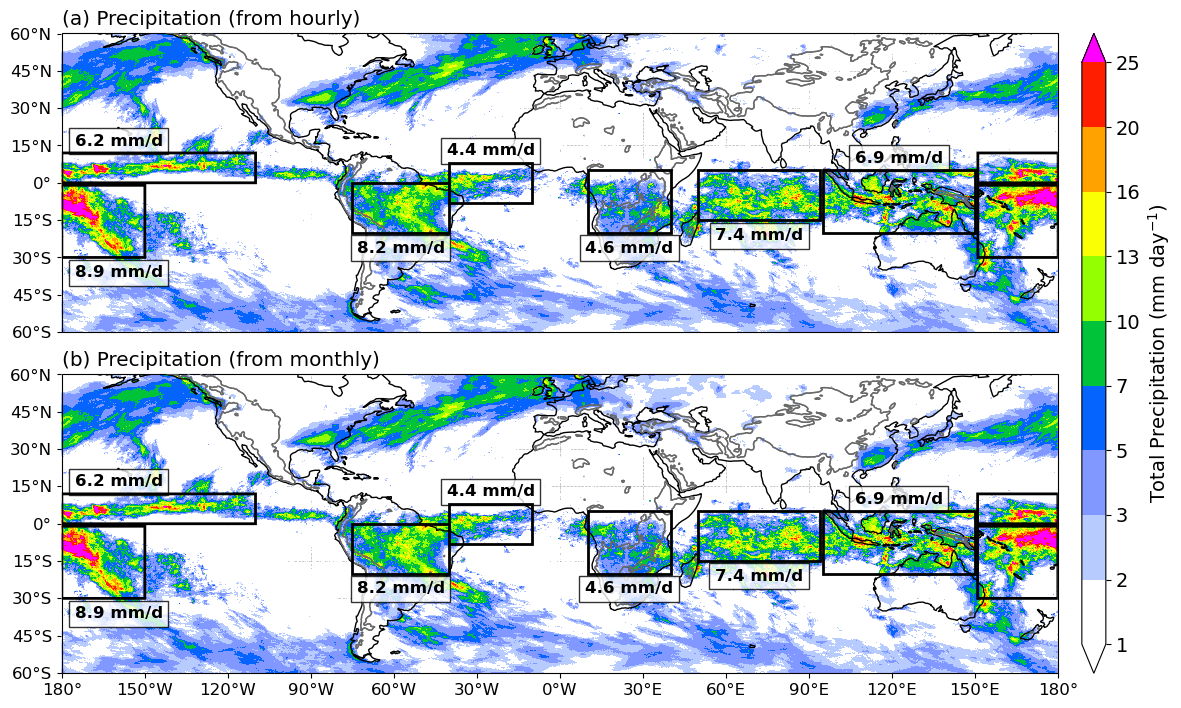

In [22]:
titles = [f'(a) Precipitation (from hourly)', f'(b) Precipitation (from monthly)']
dataarr = [pcp1, pcp2]
levels = [1,2,3,5,7,10,13,16,20,25]
cbticks = levels
cblabel = 'Total Precipitation (mm day$^{-1}$)'
cmap = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
# cmap = truncate_colormap(cmap, 0., 0.9)
figname = f'{figdir}globalmap_total_rain_OBSv7_IMERGmonthly.png'
oob_colors = {'under':'white', 'over':'magenta'}
text_val = [text_val_totpcp_s1, text_val_totpcp_s2]
text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}
fig = plot_2maps_1cb(dataarr, lon, lat, titles, levels, cmap, cblabel, cbticks, figname, 
                     contourf=False, oob_colors=oob_colors,
                     boxes=boxes, boxtextloc=text_loc, boxtext=text_val, text_colors=text_colors, boxtexttype='string')

In [23]:
def plot_2maps_2cb(dataarray, lon, lat, titles, levels, cmaps, cblabels, cbticks, figname, 
                   oob_colors=None, contourf=False, boxes=None, boxtextloc=None, boxtext=None, boxtexttype=None, text_colors=None):
    
    mpl.rcParams['font.size'] = 12
    # mpl.rcParams['font.family'] = 'Helvetica'

    map_extent = [-180., 179.5, -60.1, 60.1]
    lonv = np.arange(-180,180.1,30)
    latv = np.arange(-60,60.1,15)
    proj = ccrs.PlateCarree(central_longitude=0)
    data_proj = ccrs.PlateCarree()
    levelshgt = [1000,10000]

    fig = plt.figure(figsize=[12,8], dpi=100)
    gs = gridspec.GridSpec(2,2, height_ratios=[1,1], width_ratios=[1,0.02])
    gs.update(left=0.05, right=0.88, bottom=0.1, top=0.9, wspace=0.05, hspace=0.14)

    resolution = '110m'
    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
    
    for pp in range(0,2):
        data = dataarray[pp]

        ax = plt.subplot(gs[pp,0], projection=proj)
        ax.set_extent(map_extent, crs=proj)
        ax.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
        ax.set_title(titles[pp], loc='left')
        ax.set_aspect('auto', adjustable=None)
#         ax.add_feature(land, facecolor='lightgray')
#         ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])

        gl = ax.gridlines(crs=proj, draw_labels=False, linestyle='--', linewidth=0.5)
        gl.xlocator = mpl.ticker.FixedLocator(lonv)
        gl.ylocator = mpl.ticker.FixedLocator(latv)
            
        if (pp == 1):
            ax.set_xticks(lonv, crs=data_proj)
            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_yticks(latv, crs=data_proj)
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        
        # Terrain height
        ct = ax.contour(lon_ter, lat_ter, ter_s, levels=[1000,1001], \
                        colors='dimgray', linewidths=1, transform=data_proj, zorder=3)
        
        Zm = np.ma.masked_where(((data == 0) | (np.isnan(data))), data)
        cmap = copy.copy(mpl.colormaps.get_cmap(cmaps[pp]))
        norm = colors.BoundaryNorm(boundaries=levels[pp], ncolors=cmap.N)
        
        if (contourf == False):
            cf1 = ax.pcolormesh(lon, lat, Zm, shading='auto', norm=norm, cmap=cmap, transform=data_proj, zorder=2)
        else:
            cf1 = ax.contourf(lon, lat, Zm, levels=levels[pp], norm=norm, cmap=cmap, transform=data_proj, extend='both', zorder=2)

        if oob_colors is not None:
            cf1.cmap.set_over(oob_colors['over'])
            cf1.cmap.set_under(oob_colors['under'])
            cf1.set_clim(min(levels[pp]), max(levels[pp]))

        # Plot boxes
        if boxes is not None:
            for ii in boxes:
                # Plot region boxes
                corners = [[boxes[ii][0],boxes[ii][2]], [boxes[ii][1],boxes[ii][2]], [boxes[ii][1],boxes[ii][3]], [boxes[ii][0],boxes[ii][3]]]
                box = Polygon(corners, edgecolor='k', facecolor='none', lw=2, transform=data_proj, zorder=10)
                ax.add_patch(box)

                if boxtexttype is None:
                    text_color = text_colors['pos'] if (boxtext[pp][ii] >=0) else text_colors['neg']
                    ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[pp][ii]:.01f}%", ha='center',
                            bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
                            fontsize=12, fontweight='bold', color=text_color, transform=data_proj, zorder=4)
                else:
                    text_color = 'k'
                    ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[pp][ii]}", ha='center',
                            bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
                            fontsize=12, fontweight='bold', color=text_color, transform=data_proj, zorder=4)
                
        # Colorbars
        cax1 = plt.subplot(gs[pp,1])
        cb1 = plt.colorbar(cf1, cax=cax1, label=cblabels[pp], ticks=cbticks[pp], orientation='vertical', extend='both')
        # cb1.set_label(cblabel, fontsize=14)
        cb1.ax.tick_params(labelsize=14)
    
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

In [24]:
text_val_totpcp_diff

{'MC': 0.05485735356297046,
 'ITCZ': 0.01733725256145867,
 'SPCZ': 0.0999477247097735,
 'IO': -0.15219638461668716,
 'AO': 0.05196130378347152,
 'AFC': 0.053309200228271805,
 'AMZ': 0.03926410436281931}

In [25]:
[-5,-4,-3,-2,-1.5,-1,-0.5,-0.2,0.2,0.5,1,1.5,2,3,4,5]

array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.])

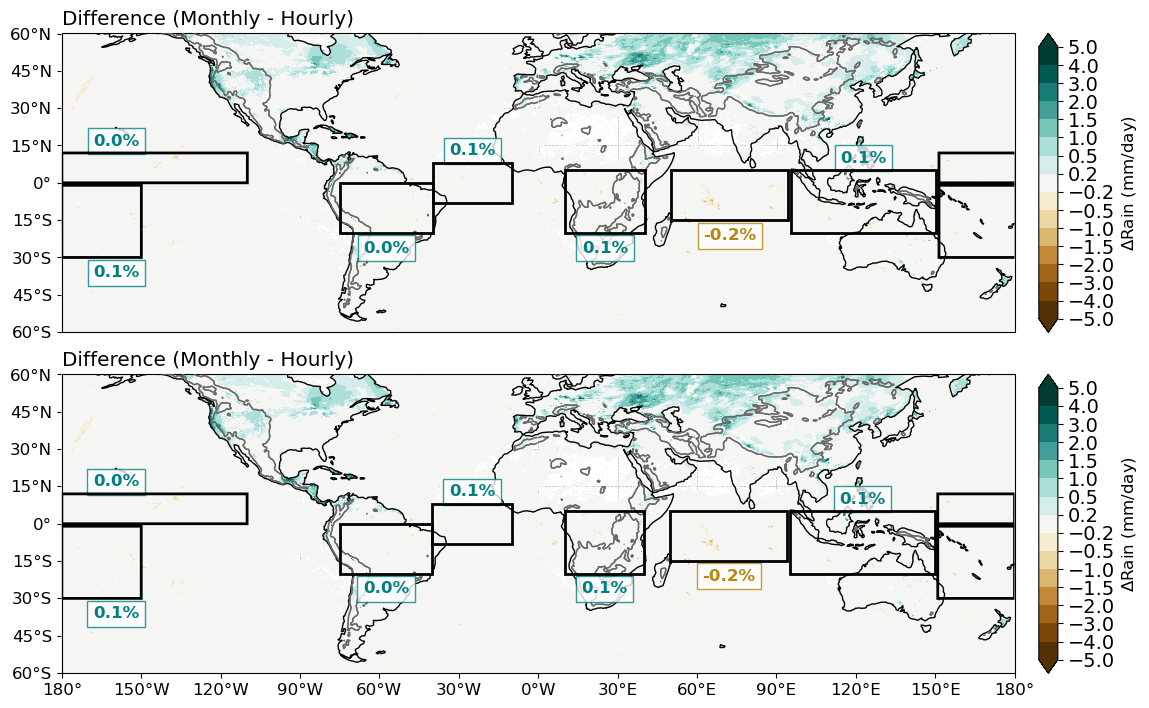

In [27]:
titles = [f'Difference (Monthly - Hourly)',f'Difference (Monthly - Hourly)']
dataarr = [pcpdiff, pcpdiff]
# lev1 = np.arange(-5, 5.1, 1)
lev1 = [-5,-4,-3,-2,-1.5,-1,-0.5,-0.2,0.2,0.5,1,1.5,2,3,4,5]
lev2 = lev1
cbticks1 = lev1
cbticks2 = lev2
levels = [lev1, lev2]
cbticks = [cbticks1, cbticks2]
cblabels = [r"$\Delta$Rain (mm/day)", r"$\Delta$Rain (mm/day)"]
cmaps = ['BrBG', 'BrBG']
text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}
text_val = [text_val_totpcp_diff, text_val_totpcp_diff]
figname = f'{figdir}globalmap_total_rain_diff_OBSv7_IMERGmonthly.png'
fig = plot_2maps_2cb(dataarr, lon, lat, titles, levels, cmaps, cblabels, cbticks, figname, contourf=False,
                     boxes=boxes, boxtextloc=text_loc, boxtext=text_val, text_colors=text_colors)